<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/3.3.1-LSTMB-1mil-random_under_sampling-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype (Balanced Weights)

LSTM is generally doing pretty good in our deep learning models. In our last notebook, we ran LSTM network with default weights - ie, penalty for mis-classification is the same across all classes.

In this notebook, we will use 'balanced' weights calculated by sklearn's compute_class_weight with 1 million training examples to see how this affects our performance

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru
import util.metric_util as mu



logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False
RSTATE=1


MODEL_NAME = "LSTMB"
LSTM_DIM = 64 # total LSTM units
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units and 20% 1D Spatial Dropout - Balanced Weights - Random Under Sampling"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 8
sampler = RandomUnderSampler(random_state=RSTATE, sampling_strategy='not majority')

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-1m-preprocessed.csv"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]



# Preprocessing

# Under sample

In [4]:
# def sample_data(X_train, y_train, description: str):
#   print(f'X_train shape {X_train.shape}')
#   print(f'y_train shape {y_train.shape}')
#   print(f'y_train columns {y_train.columns}')
#   original_size = X_train.shape[0]
#   sampler = RandomUnderSampler(random_state=RSTATE, sampling_strategy='not majority')
#   X_train_res, y_train_res = sampler.fit_resample(X_train, y_train.ravel())

#   X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
#   y_train = pd.DataFrame(y_train_res, columns=["star_rating"])

#   # get distribution of samples after samping
#   dist = y_train.reset_index().groupby("star_rating").count()

#   log.info(f'Distribution after sampling with {SAMPLING_METHOD}\n{dist}')

#   log.debug(dist.head())
#   dist.to_csv(f'{DATA_DIR}/reports/{description}-{original_size}-histogram-{SAMPLING_METHOD}.csv')
#   return X_train, y_train


# # split our data into train and test sets
# reviews_train, reviews_test, y_train_unencoded, y_test_unencoded = \
#                 train_test_split(reviews, rating, random_state=1, test_size=0.1)


# # Pre-process our features (review body)
# t = Tokenizer()
# # fit the tokenizer on the documents
# t.fit_on_texts(reviews_train)
# # tokenize both our training and test data
# train_sequences = t.texts_to_sequences(reviews_train)
# test_sequences = t.texts_to_sequences(reviews_test)

# print("Vocabulary size={}".format(len(t.word_counts)))
# print("Number of Documents={}".format(t.document_count))


# # pad our reviews to the max sequence length
# X_train_unsampled = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
# X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# X_train, y_train_sampled_unencoded = sample_data(X_train_unsampled, y_train_unencoded, MODEL_NAME)

# # pre-process our lables
# # one hot encode our star ratings since Keras/TF requires this for the labels
# y_train = OneHotEncoder().fit_transform(y_train_sampled_unencoded.values.reshape(len(rating), 1)).toarray()
# y_test = OneHotEncoder().fit_transform(y_test_unencoded.values.reshape(len(rating), 1)).toarray()


# print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)
import importlib
importlib.reload(ku)

X_train, X_test, y_train, y_test, t = ku.preprocess_file(df, 
                                                      FEATURE_COLUMN, 
                                                      LABEL_COLUMN,
                                                      report_dir = f'{DRIVE_DIR}/reports',
                                                      use_oov_token = True,
                                                      sampler = sampler,
                                                      )


Vocabulary size=129436
Number of Documents=995688
Splitting data into training and test sets...
Training X shape (746766, 100) y shape (746766,)
Test X shape (248922, 100) y shape (248922,)
Start sampling with RandomUnderSampler
Resampled X shape (597485, 100) y shape (597485,)
Resampled distribution:
    index
0        
1   49287
2   49287
3   49287
4   49287
5  400337
One hot enocde label data...


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts) + 1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          38831100  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 38,924,865
Trainable params: 38,924,865
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')



mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42284845 3.02709736 2.2103805  1.20013018 0.37296994]
Number of training examples: 597485
Train on 477988 samples, validate on 119497 samples
Epoch 1/50
477988/477988 [==============================] - 2022s 4ms/sample - loss: 0.7957 - categorical_accuracy: 0.6980 - val_loss: 0.2123 - val_categorical_accuracy: 0.9680
Epoch 2/50
477988/477988 [==============================] - 2020s 4ms/sample - loss: 0.6966 - categorical_accuracy: 0.7333 - val_loss: 0.2360 - val_categorical_accuracy: 0.9582
Epoch 3/50
477988/477988 [==============================] - 2018s 4ms/sample - loss: 0.6505 - categorical_accuracy: 0.7523 - val_loss: 0.2119 - val_categorical_accuracy: 0.9557
Epoch 4/50
477988/477988 [==============================] - 2002s 4ms/sample - loss: 0.6076 - categorical_accuracy: 0.7703 - val_loss: 0.2544 - val_categorical_accuracy: 0.9405
Epoch 5/50
477988/477988 [==============================] - 1998s 4ms/sample - loss: 0.5677 - categorical_accuracy: 0.7867 - val_los

Number of test: 248922
Running model.evaluate...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(248922, 5)
Getting classification report...
Accuracy: 68.90%


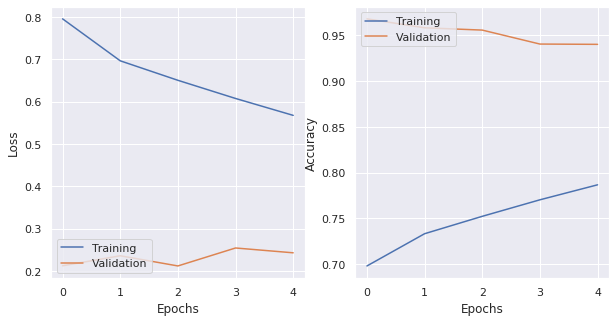


Confusion Matrix
[[ 22701   8520   1775    269   1898]
 [  4233   7018   3083    454   1710]
 [  1818   4950   7911   2305   5375]
 [   565   1451   4887   8226  26186]
 [   772    987   2282   3904 125642]]

Classification Report
              precision    recall  f1-score   support

           1       0.75      0.65      0.70     35163
           2       0.31      0.43      0.36     16498
           3       0.40      0.35      0.37     22359
           4       0.54      0.20      0.29     41315
           5       0.78      0.94      0.85    133587

    accuracy                           0.69    248922
   macro avg       0.56      0.51      0.51    248922
weighted avg       0.67      0.69      0.66    248922



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

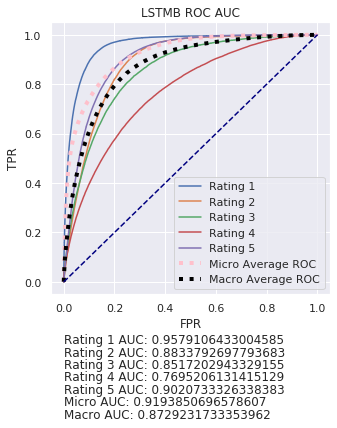

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

INFO:util.report_util:calculating metric from dictionary
INFO:util.report_util:got all values to calculate


Score: 0.3837741337036844


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB-1x64-random_embedding-sampling_none-846407-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB-1x64-random_embedding-sampling_none-846407-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB-1x64-random_embedding-sampling_none-846407-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB-1x64-random_embedding-sampling_none-846407-100-star_rating-weights.h5


INFO:root:Saving tokenizer file: drive/My Drive/Springboard/capstone/models/dl-tokenizer.pkl


Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'LSTMB', 'architecture': '1x64', 'description': '1 Layer 64 LSTM Units and 20% 1D Spatial Dropout - Balanced Weights - Random Under Sampling', 'classification_report': '{"1": {"precision": 0.7544617634351424, "recall": 0.6455933794044877, "f1-score": 0.6957947649114204, "support": 35163}, "2": {"precision": 0.3061153275756783, "recall": 0.42538489513880473, "f1-score": 0.3560267857142857, "support": 16498}, "3": {"precision": 0.3967800180559735, "recall": 0.35381725479672615, "f1-score": 0.3740690829136818, "support": 22359}, "4": {"precision": 0.5426837313629767, "recall": 0.19910444148614304, "f1-score": 0.2913250579923149, "support": 41315}, "5": {"precision": 0.7813022740981649, "recall": 0.9405256499509683, "f1-score": 0.8535519942390913, "support": 133587}, "accuracy": 0.

In [11]:
print(datetime.now())

2019-11-09 23:14:09.069620
